In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carga y limpieza de datos

## (Hecho con la info obtenida en el notebook LimpiezaDeDatos)

In [2]:
#import io
#ruta = io.StringIO(uploaded['train.csv'].decode('utf-8'))
ejemplo =  pd.read_csv('data/ejemploRespuesta.csv', names = ["id", "precio"] )
test =  pd.read_csv('data/test.csv', parse_dates = ['fecha'])
train = pd.read_csv('data/train.csv',parse_dates = ['fecha'])

In [3]:
#A los nulls los relleno con el promedio de metroscubiertos de todas las publicaciones
train['metroscubiertos']=train['metroscubiertos'].fillna(round(train['metroscubiertos'].mean()))
test['metroscubiertos']=test['metroscubiertos'].fillna(round(test['metroscubiertos'].mean()))
#Luego convierto metroscubiertos a  np.int16
train['metroscubiertos']=train['metroscubiertos'].astype(np.int16)
test['metroscubiertos']=test['metroscubiertos'].astype(np.int16)

In [4]:
#A los nulls los relleno con el promedio de metrostotales de todas las publicaciones
train['metrostotales']=train['metrostotales'].fillna(round(train['metrostotales'].mean()))
test['metrostotales']=test['metrostotales'].fillna(round(test['metrostotales'].mean()))
#Luego convierto metrostotales a  np.int16
train['metrostotales']=train['metrostotales'].astype(np.int16)
test['metrostotales']=test['metrostotales'].astype(np.int16)

In [5]:
#El precio promedio de las publicaciones que no tienen datos de cant de habitaciones esta entre el precio
#promedio de las que tienen 2 y 3 habitaciones
#Entonces voy a asumir que tienen 3 habitaciones, ya que es el valor al cual el precio mas se les asemeja.
train['habitaciones']=train['habitaciones'].fillna(3)
test['habitaciones']=test['habitaciones'].fillna(3)
#Luego convierto a np.int8
train['habitaciones']=train['habitaciones'].astype(np.int8)
test['habitaciones']=test['habitaciones'].astype(np.int8)

In [6]:
#A los que no tienen datos de antiguedad los relleno con la antiguedad promedio (es 8)
train['antiguedad']=train['antiguedad'].fillna(round(train['antiguedad'].mean()))
test['antiguedad']=test['antiguedad'].fillna(round(train['antiguedad'].mean()))
#Luego convierto a np.uint8
train['antiguedad']=train['antiguedad'].astype(np.uint8)
test['antiguedad']=test['antiguedad'].astype(np.uint8)

In [7]:
#El precio promedio de los que tienen NULL en garage es parecido al de los que tienen 2.
#Relleno los nulls de esta columna con un 2.
train['garages']=train['garages'].fillna(2)
test['garages']=test['garages'].fillna(2)
#convierto a np.int8
train['garages']=train['garages'].astype(np.int8)
test['garages']=test['garages'].astype(np.int8)

In [8]:
#El precio promedio de los que tienen NULL en banos es mas parecido al de los que tienen 2.
#Relleno los nulls de esta columna con un 2.
train['banos']=train['banos'].fillna(2)
test['banos']=test['banos'].fillna(2)
#convierto a np.int8
train['banos']=train['banos'].astype(np.int8)
test['banos']=test['banos'].astype(np.int8)

In [9]:
train['gimnasio']=train['gimnasio'].astype(np.int8)
train['usosmultiples']=train['usosmultiples'].astype(np.int8)
train['piscina']=train['piscina'].astype(np.int8)
train['escuelascercanas']=train['escuelascercanas'].astype(np.int8)
train['centroscomercialescercanos']=train['centroscomercialescercanos'].astype(np.int8)
test['gimnasio']=test['gimnasio'].astype(np.int8)
test['usosmultiples']=test['usosmultiples'].astype(np.int8)
test['piscina']=test['piscina'].astype(np.int8)
test['escuelascercanas']=test['escuelascercanas'].astype(np.int8)
test['centroscomercialescercanos']=test['centroscomercialescercanos'].astype(np.int8)

In [10]:
#Creo categoria para los que no tienen categoria en provincia:
train['provincia']=train['provincia'].fillna('N/A')
test['provincia']=test['provincia'].fillna('N/A')
#Creo categoria para los que no tienen categoria en ciudad:
train['ciudad']=train['ciudad'].fillna('N/A')
test['ciudad']=test['ciudad'].fillna('N/A')
#Relleno los nulls en direccion con un - .
train['direccion']=train['direccion'].fillna('-')
test['direccion']=test['direccion'].fillna('-')
#Creo categoria para los que no tienen categoria en tipodepropiedad:
train['tipodepropiedad']=train['tipodepropiedad'].fillna('N/A')
test['tipodepropiedad']=test['tipodepropiedad'].fillna('N/A')

In [11]:
train['titulo']=train['titulo'].fillna(' ')
train['descripcion']=train['descripcion'].fillna(' ')
test['titulo']=test['titulo'].fillna(' ')
test['descripcion']=test['descripcion'].fillna(' ')

In [12]:
train['precio']=train['precio'].astype(np.int32)
train['id']=train['id'].astype(np.int32)
test['id']=test['id'].astype(np.int32)

In [13]:
#Algunas columnas tienen nulls que no se como encararlos. Por ahora los relleno con 0
train=train.fillna(0)
test=test.fillna(0)

# Armado de features:

In [14]:
train.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

In [15]:
test.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos'],
      dtype='object')

## Dummies para tipodepropiedad

In [16]:
#Voy a usar OneHotEncoder para convertir la columna categorica tipodepropiedad en dummies.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
dummies = enc.fit_transform(train['tipodepropiedad'].values.reshape(-1, 1)).toarray()
dummies = pd.DataFrame(dummies)
dummies_test = enc.transform(test['tipodepropiedad'].values.reshape(-1, 1)).toarray()
dummies_test = pd.DataFrame(dummies_test)

In [17]:
dummies=dummies.add_prefix('tipodepropiedad_')
dummies=dummies.astype(np.int8)
dummies_test=dummies_test.add_prefix('tipodepropiedad_')
dummies_test=dummies_test.astype(np.int8)

In [18]:
dummies.head()

,tipodepropiedad_0,tipodepropiedad_1,tipodepropiedad_2,tipodepropiedad_3,tipodepropiedad_4,tipodepropiedad_5,tipodepropiedad_6,tipodepropiedad_7,tipodepropiedad_8,tipodepropiedad_9,...,tipodepropiedad_15,tipodepropiedad_16,tipodepropiedad_17,tipodepropiedad_18,tipodepropiedad_19,tipodepropiedad_20,tipodepropiedad_21,tipodepropiedad_22,tipodepropiedad_23,tipodepropiedad_24
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
dummies_test.head()

,tipodepropiedad_0,tipodepropiedad_1,tipodepropiedad_2,tipodepropiedad_3,tipodepropiedad_4,tipodepropiedad_5,tipodepropiedad_6,tipodepropiedad_7,tipodepropiedad_8,tipodepropiedad_9,...,tipodepropiedad_15,tipodepropiedad_16,tipodepropiedad_17,tipodepropiedad_18,tipodepropiedad_19,tipodepropiedad_20,tipodepropiedad_21,tipodepropiedad_22,tipodepropiedad_23,tipodepropiedad_24
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Features sobre el tiempo

En el TP1 vimos como los precios iban en aumento a medida que el tiempo aumentaba, por lo que nos interesa crear nuevos features tomando en cuenta el tiempo en el que se publicaron las propiedades.


Para realizar un nuevo feature comenzaremos añadiendo un peso para cada fecha, este peso irá en aumento a medida que las fechas van subiendo, así simularemos el crecimiento del precio a lo largo del tiempo.

In [20]:
#Califico las fechas de acuerdo a la diferencia entre la fecha actual y la fecha mínima sobre el máximo de dias
fecha_min = train.fecha.min()
fecha_max = train.fecha.max()
delta_max_days = (fecha_max - fecha_min).days
def calificar_fecha(fecha):
    delta = fecha - fecha_min
    return delta.days/delta_max_days

In [21]:
train["puntaje_por_fecha"] = train['fecha'].transform(lambda x: calificar_fecha(x))
train.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,puntaje_por_fecha
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,8,2,1,...,0.000000,0.000000,2015-08-23,0,0,0,0,0,2273000,0.728368
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10,3,2,...,19.310205,-99.227655,2013-06-28,0,0,0,1,1,3600000,0.297919
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5,3,2,...,0.000000,0.000000,2015-10-17,0,0,0,0,0,1200000,0.758488
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1,2,1,...,19.301890,-99.688015,2012-03-09,0,0,0,1,1,650000,0.037240
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10,2,1,...,0.000000,0.000000,2016-06-07,0,0,0,0,0,1150000,0.886637


In [22]:
#Set de test
fecha_min = test.fecha.min()
fecha_max = test.fecha.max()
delta_max_days = (fecha_max - fecha_min).days
test["puntaje_por_fecha"] = test['fecha'].transform(lambda x: calificar_fecha(x))
test.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,puntaje_por_fecha
0,4941,"casa en venta en miguel hidalgo, distrito federal",<p>excelente casa estilo moderno.</p>,Casa,Bosque de Cedros,Miguel Hidalgo,Distrito Federal,29,3,2,...,0.0,19.408668,-99.246767,2013-07-20,0,0,0,0,0,0.309967
1,51775,departamentos en venta en montebello,<p>departamento una recamara:\n</p><p>departam...,Apartamento,-,Mérida,Yucatán,8,1,1,...,113851.0,21.032480,-89.592424,2015-10-24,0,0,0,0,0,0.762322
2,115253,departamento nuevo delegación coyoacán de 87 m...,"departamento nuevo de 87.06 m2, 1 cajón de est...",Apartamento,"Pueblo de los Reyes, Coyoacán, Mexico D.F.",Coyoacán,Distrito Federal,0,2,1,...,23620.0,19.332829,-99.152913,2015-05-30,0,0,0,0,1,0.681818
3,299321,departamento en venta en acapulco,<p> raíces dv001 precioso departamento tipo k...,Apartamento,-,Acapulco de Juárez,Guerrero,2,2,2,...,129347.0,16.860487,-99.878383,2015-04-02,0,0,0,0,0,0.650055
4,173570,bonita casa sola equipada de dos niveles en lo...,"<p>casa sola, bonita de dos rec&aacute;maras u...",Casa,CEDROS,Tultitlán,Edo. de México,10,2,1,...,57125.0,19.640482,-99.127273,2013-08-15,0,0,0,1,1,0.324206


**Pruebo el modelo con este nuevo feature**

In [24]:
Numericos=['antiguedad','habitaciones','garages','banos','metroscubiertos',\
            'metrostotales','gimnasio','usosmultiples','piscina','escuelascercanas',\
            'centroscomercialescercanos','puntaje_por_fecha']

In [25]:
X=train[Numericos].join(dummies)
Y=train['precio']

In [26]:
X.head()

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,...,tipodepropiedad_15,tipodepropiedad_16,tipodepropiedad_17,tipodepropiedad_18,tipodepropiedad_19,tipodepropiedad_20,tipodepropiedad_21,tipodepropiedad_22,tipodepropiedad_23,tipodepropiedad_24
0,8,2,1,2,80,80,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,3,2,2,268,180,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,5,3,2,2,144,166,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,1,1,63,67,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10,2,1,1,95,95,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
Y.head()

0    2273000
1    3600000
2    1200000
3     650000
4    1150000
Name: precio, dtype: int32

In [31]:
X_test = test[Numericos].join(dummies_test)
X_test.head()

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,...,tipodepropiedad_15,tipodepropiedad_16,tipodepropiedad_17,tipodepropiedad_18,tipodepropiedad_19,tipodepropiedad_20,tipodepropiedad_21,tipodepropiedad_22,tipodepropiedad_23,tipodepropiedad_24
0,29,3,2,4,300,176,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,1,1,1,67,67,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,1,2,87,100,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,2,2,2,86,86,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,2,1,1,80,76,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Armado de modelos

In [32]:
def crear_submit(model, x_train, y_train, x_test, nombre):
    model.fit(x_train, y_train)
    result = model.predict(x_test)
    final = test.loc[:, ['id']]
    final['target'] = result
    ruta = "data/submit"+ nombre +".csv"
    final.to_csv(path_or_buf = ruta, index = False )
    df = pd.read_csv(ruta)
    return df

In [33]:
from sklearn import preprocessing 
def normalizar_data(df):
    min_max_scaler = preprocessing.MinMaxScaler() 
    np_scaled = min_max_scaler.fit_transform(df)
    return pd.DataFrame(np_scaled)

In [34]:
from sklearn.model_selection import cross_val_score

# BaseLine para nuestros modelos

## (1) KNN

In [35]:
from sklearn.neighbors import KNeighborsRegressor

In [36]:
#Por default toma n = 5
KNN_model = KNeighborsRegressor()

In [37]:
KNN_model.fit(X,Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

**Mido el resultado de knn utilizando la métrica MAE**

In [38]:
# Con cross validation y n=5
scores = cross_val_score(KNN_model , X, Y, scoring="neg_mean_absolute_error", cv=10)
KNN_mae_score1 = -scores.mean()
KNN_mae_score1

967336.783135

In [39]:
# Otra Alternativa
from sklearn import metrics 
from sklearn.model_selection import train_test_split 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = None)   

KNN_model.fit(X_train, Y_train) 
  
Y_pred = KNN_model.predict(X_test) 
  
KNN_mae_score2 = metrics.mean_absolute_error(Y_test, Y_pred) 
KNN_mae_score2


971195.8960666668

## (2) Linear Regression

In [40]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression().fit(X, Y)
scores = cross_val_score(LR_model , X, Y, scoring="neg_mean_absolute_error", cv=10)
LR_score1 = -scores.mean()

In [41]:
LR_score1

1025762.7966656338

**Evidentemente es mucho peor que KNN**

## (3) Árbol de Decisión

In [42]:
from sklearn.tree import DecisionTreeRegressor

DTR_model = DecisionTreeRegressor().fit(X, Y)
scores = cross_val_score(DTR_model , X, Y, scoring="neg_mean_absolute_error", cv=10)
DTR_score1 = -scores.mean()
DTR_score1

1112586.3117073714

# Probamos más modelos

## (1) Random Forest

In [43]:
from sklearn.ensemble  import RandomForestRegressor

RF_model=RandomForestRegressor()

RF_model.fit(X,Y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

### MAE score para RF

In [44]:
scores = cross_val_score(RF_model , X, Y, scoring="neg_mean_absolute_error", cv=10)
RF_mae_score1 = -scores.mean()
RF_mae_score1

865143.970407656

In [45]:
importancias = pd.DataFrame(RF_model.feature_importances_,index=X.columns,columns=['importancia']).reset_index()
importancias.columns = ['feature', 'importancia']

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 <a list of 10 Text yticklabel objects>)

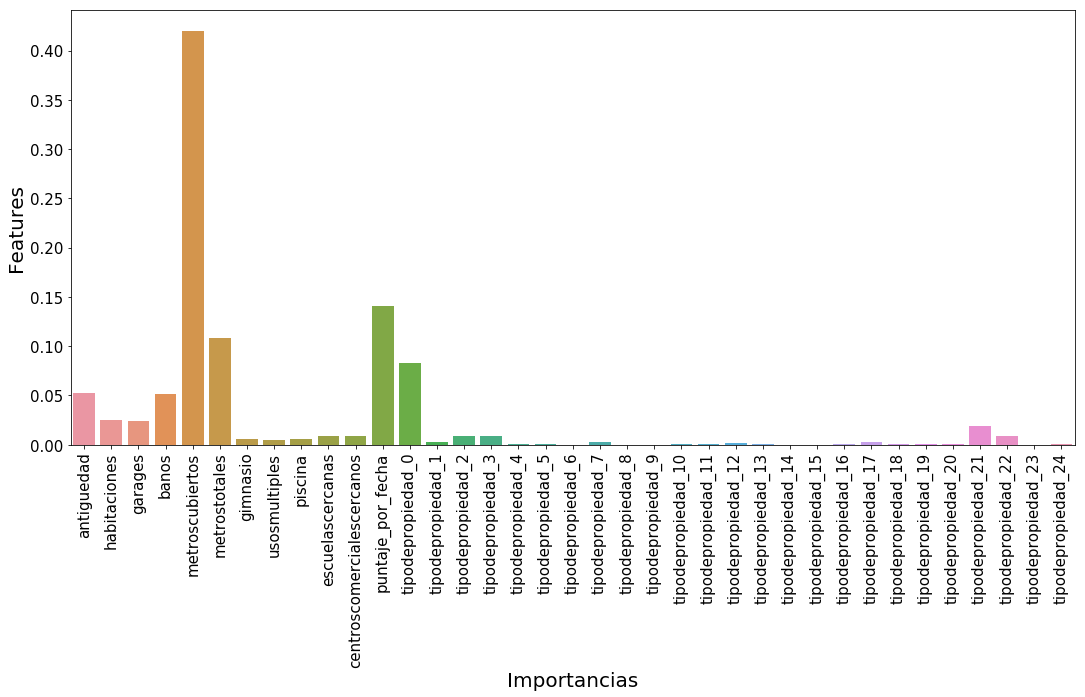

In [46]:
import seaborn as sns
plt.figure(figsize = (18,8))
graf = sns.barplot(x = importancias.feature, y = importancias.importancia, orient = 'v')
graf.set_xlabel("Importancias", fontsize = 20)
graf.set_ylabel("Features", fontsize = 20)
plt.xticks(fontsize = 15, rotation = 'vertical')
plt.yticks(fontsize = 15)

## (2) Gradient Boosting

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

GBR_model = GradientBoostingRegressor(random_state=23, n_estimators=50, min_samples_split=50).fit(X, Y)
scores = cross_val_score(GBR_model , X, Y, scoring="neg_mean_absolute_error", cv=10)
GBR_mae_score1 = -scores.mean()
GBR_mae_score1

933692.0618025201

## Submit con Random Forest

## Hago un submit con los datos normalizados

In [49]:
X_normalized = normalizar_data(X)
X_test_normalized = normalizar_data(X_test)

In [50]:
X_test_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.2500,0.000000,0.333333,0.000000,0.127358,0.382075,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.2625,0.111111,0.000000,0.000000,0.106132,0.382075,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0750,0.222222,0.666667,0.333333,0.490566,0.332547,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0000,0.222222,0.666667,0.333333,0.356132,0.247642,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.1000,0.222222,0.000000,0.333333,0.306604,0.306604,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [51]:
scores = cross_val_score(RF_model , X_normalized, Y, scoring="neg_mean_absolute_error", cv=10)
RF_mae_score1 = -scores.mean()
RF_mae_score1

866097.4553711808

In [ ]:
submit1 = crear_submit(RF_model,X_normalized, Y, X_test_normalized, "RF_normalized")
submit1.head()

## submit

In [ ]:
df = crear_submit(GBR_model, X_normalized,Y, X_test_normalized, "RF_normalized")
df.head()